# Analisi di un catalogo di ammassi di galassie

L'esercizio consiste nell'analizzare un catalogo di ammassi di galassie (`euclid_clusters.csv`) con caratteristiche simili a quelli che saranno osservati dalla missione Euclid. Il catalogo fornisce la massa (in masse solari) per ogni ammasso, per tre bin di redshift, ed il volume di universo associato a ciascun bin (in ${Mpc}^3/h^3$).

### Pacchetti e librerie utilizzati

In [3]:
import pandas as pd
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
import numpy as np

## Parte uno: visualizzazione e analisi dei dati

_Scaricare il catalogo degli ammassi di galassie e analizzarne i dati, prestando particolare attenzione alla distribuzione delle masse degli ammassi. Si suggerisce di utilizzare scale logaritmiche per verificare la distribuzione dei dati._

Per prima cosa importo i dati del catalogo su un dataframe. <br/>
Tengo conto dell'indicizzazione della prima colonna specificando l'argomento `index_col = 0`.

In [6]:
# importing data-frame 
euclid_clusters = pd.read_csv("euclid_clusters.csv", index_col = 0)

# checking goodness of dataframe
euclid_clusters.head()

,mass,z,vol
0,1.060613e+14,0.506,1.479387e+10
1,1.097076e+14,0.506,1.479387e+10
2,1.588869e+14,0.506,1.479387e+10
3,1.336345e+14,0.506,1.479387e+10
4,3.078288e+14,0.506,1.479387e+10


Dopo aver importato il dataframe ed essermi assicurato che venga rappresentato correttamente, effettuo una prima analisi dei dati con la funzione `.hist()`. <br/>

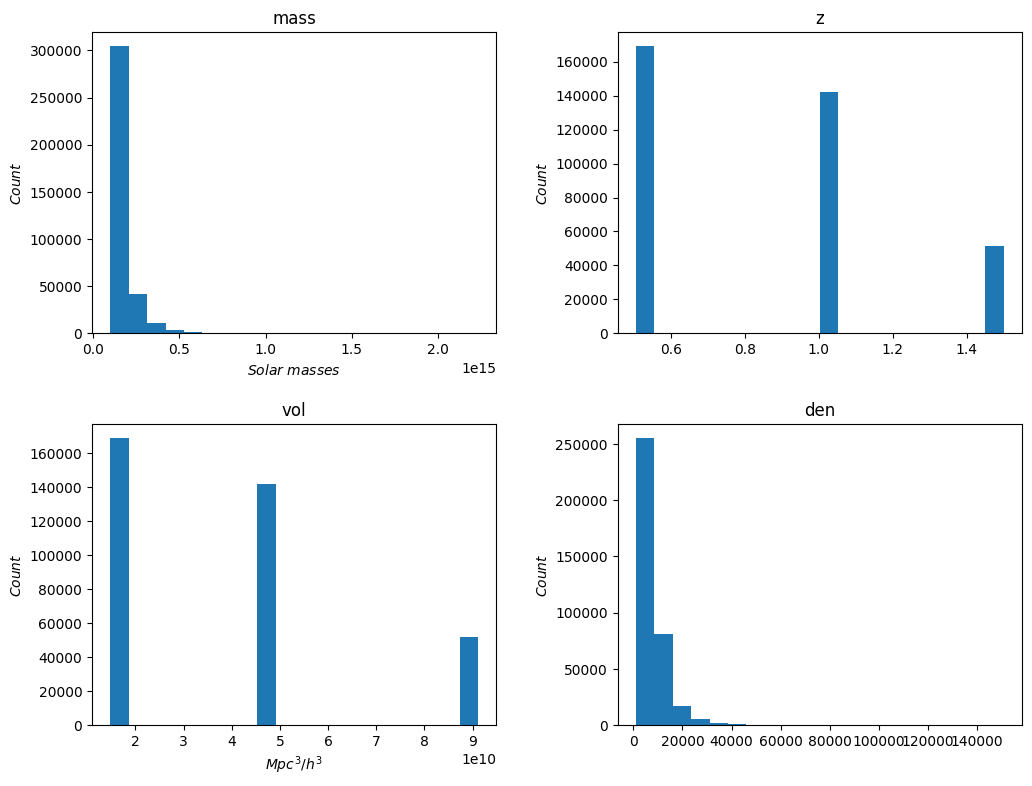

In [59]:
# plotting histograms for each column
axes = euclid_clusters.hist(grid = False, bins = "sturges", figsize = (12, 9))
axes[0][0].set_xlabel("$Solar\ masses$")
axes[1][0].set_xlabel("${Mpc}^3/h^3$")
for ax in axes.flatten():
    ax.set_ylabel("$Count$")
plt.show()

I precedenti istogrammi permettono di trarre una serie di conclusioni:

1. qualitativamente la distribuzione delle masse segue una decrescita esponenziale;
2. i tre bin di redshift non contengono lo stesso numero di ammassi di galassie;
3. il numero di galassie per ogni bin decresce con la distanza e con il volume occupato.

In particolare, la 1. giustifica il passaggio alle scale logaritmiche per studiare la distribuzione dei dati, mentre la 3. mi permette di concludere che il volume di universo associato ad ogni bin di redshift è inversamente proporzionale al redshift stesso.

Posso modellizzare la distribuzione delle masse come
\begin{equation}
    f(x) = \frac{1}{\alpha}e^{-x/\alpha}
\end{equation}
che ha come valore di aspettazione $E[x] = \alpha$ e come varianza $var[x] = {\alpha}^2$. <br/>
Verifico questa ipotesi calcolando stimando il valore di aspettazione e la varianza delle masse nel catalogo usando la funzione `.describe()`.

In [10]:
# analyzing dataframe
euclid_clusters['mass'].describe()

count    3.626370e+05
mean     1.607993e+14
std      8.356439e+13
min      1.000004e+14
25%      1.131938e+14
50%      1.337282e+14
75%      1.756083e+14
max      2.231156e+15
Name: mass, dtype: float64

Dette $\mu$ e $\sigma^2$ le stime del valore di aspettazione e della varianza, ottengo
\begin{equation}
    \mu = 1.61 \cdot 10^{14}
\end{equation}
\begin{equation}
    \sigma^2 = (8.36 \cdot 10^{13})^2
\end{equation}

Noto che $\mu \neq \sqrt{\sigma^2}$ e che pertanto la distribuzione delle masse non può essere esponenziale. <br/>
In mancanza di altre ipotesi, è comunque interessante tracciare un grafico in scala logaritmica dall'istogramma normalizzato sovrapposto a delle distribuzioni esponenziali di parametro $\mu$ e $\sqrt{\sigma^2}$.

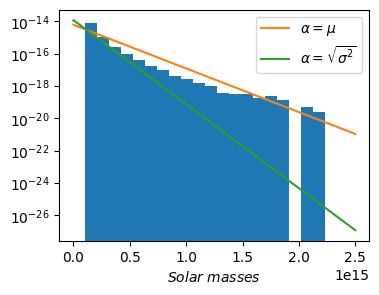

In [57]:
# plotting normalized histogram
euclid_clusters["mass"].hist(grid = False, bins = "sturges", figsize = (4, 3), log = True, density = True)

# defining distribution and parameters
mu = euclid_clusters["mass"].mean()
sigma = euclid_clusters["mass"].std()
def f(x, a):
    return np.exp(-x/a)/a
x = np.linspace(0, 2.5e15)

# plotting distributions
plt.plot(x, f(x, mu), label = r"$\alpha = \mu$")
plt.plot(x, f(x, sigma) , label = r"$\alpha = \sqrt{\sigma^2}$")
plt.xlabel("$Solar\ masses$")
plt.legend()
plt.show()

Noto così che l'andamento dei dati, almeno da un punto di vista qualitativo, si adatta meglio al caso $\alpha = \mu$ che a quello $\alpha = \sqrt{\sigma^2}$.

Successivamente analizzo i dati relativi alle masse all'interno del dataframe tramite i comandi `.groupby()` e `.describe()`; in questo modo ricavo le medie, le deviazioni standard, i percentili e valori massimi e minimi delle masse per ogni bin di redshift.

In [14]:
# analyzing data-frame
euclid_clusters.groupby('z')['mass'].describe()

,count,mean,std,min,25%,50%,75%,max
z,,,,,,,,
0.506,168897.0,1.754502e+14,1.022009e+14,1.000004e+14,1.162374e+14,1.417421e+14,1.942476e+14,2.231156e+15
1.019,142007.0,1.520161e+14,6.478489e+13,1.000036e+14,1.120814e+14,1.307558e+14,1.668826e+14,1.536768e+15
1.500,51733.0,1.370772e+14,4.304113e+13,1.000017e+14,1.093389e+14,1.230673e+14,1.487753e+14,9.605430e+14


Infine rappresento le distribuzioni delle masse tramite degli istogrammi in cui i conteggi seguono una scala logaritmica. Come prima, considero separatamente i tre bin di redshift tramite una tecnica di group-by.

Il **titolo** dei vari istogrammi corrisponde al **redshift** considerato.

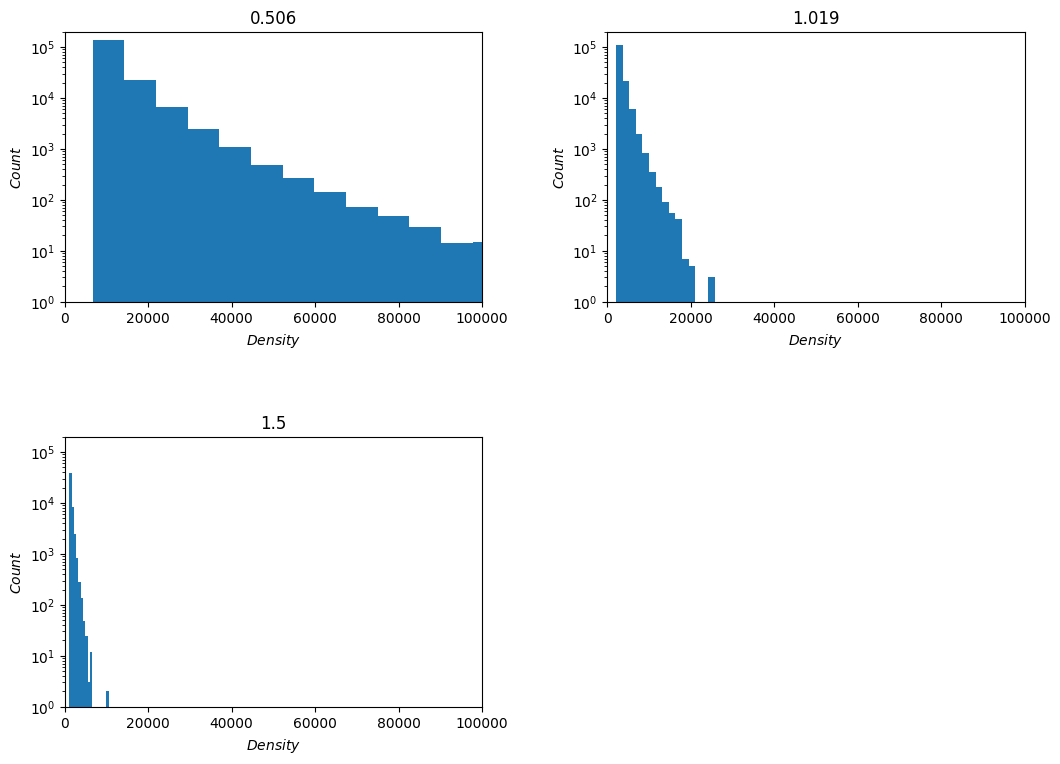

In [63]:
euclid_clusters['den'] = euclid_clusters['mass'].div(euclid_clusters['vol'])
# drawing histograms
axes = euclid_clusters.hist(['den'], by = 'z', xrot = 0, figsize = (12, 9), bins = 'sturges', log = True)
for ax in axes.flatten():
    ax.set(xlabel = '$Density$', xlim = (0, 1e5), 
           ylabel = '$Count$', ylim = (1, 2e5))

## Parte due: analisi della Halo Mass Function (HMF)
_Analizzare ogni bin di redshift individualmente e confrontare la distribuzione osservata delle masse degli ammassi (Halo Mass Function, HMF) con la distribuzione teorica predetta da diversi parametri cosmologici per verificarne la dipendenza._

Come suggerito, utilizzo la libreria Colossus. <br/>
Inizializzo i parametri cosmologici (`params`) e imposto la cosmologia come nel frammento di codice dato.

In [19]:
# initializing cosmological parameters
params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.96}

# setting cosmology
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

Per lavorare con ogni bin separatamente suddivido il dataframe originale in tre sottinsiemi in base al redshift:
 - `z1` = 0.506;
 - `z2` = 1.019;
 - `z3` = 1.500.

Per la suddivisione utilizzo gli indici ricavati nella prima parte del notebook:

In [21]:
# creating subframes
z1 = euclid_clusters.iloc[:168897]
z2 = euclid_clusters.iloc[168897:310904]
z3 = euclid_clusters.iloc[310904:]

La libreria Colossus mi permette di calcolare le distribuzioni cumulative della densità di aloni osservati (`mfunc`), dato un redshift z. La densità è espressa in masse solari per unità di volume osservato (in ${Mpc}^3/h^3$) per bin logaritmico naturale di massa. <br/>
Nell'immagine si possono visualizzare le predizioni per ogni redshift.

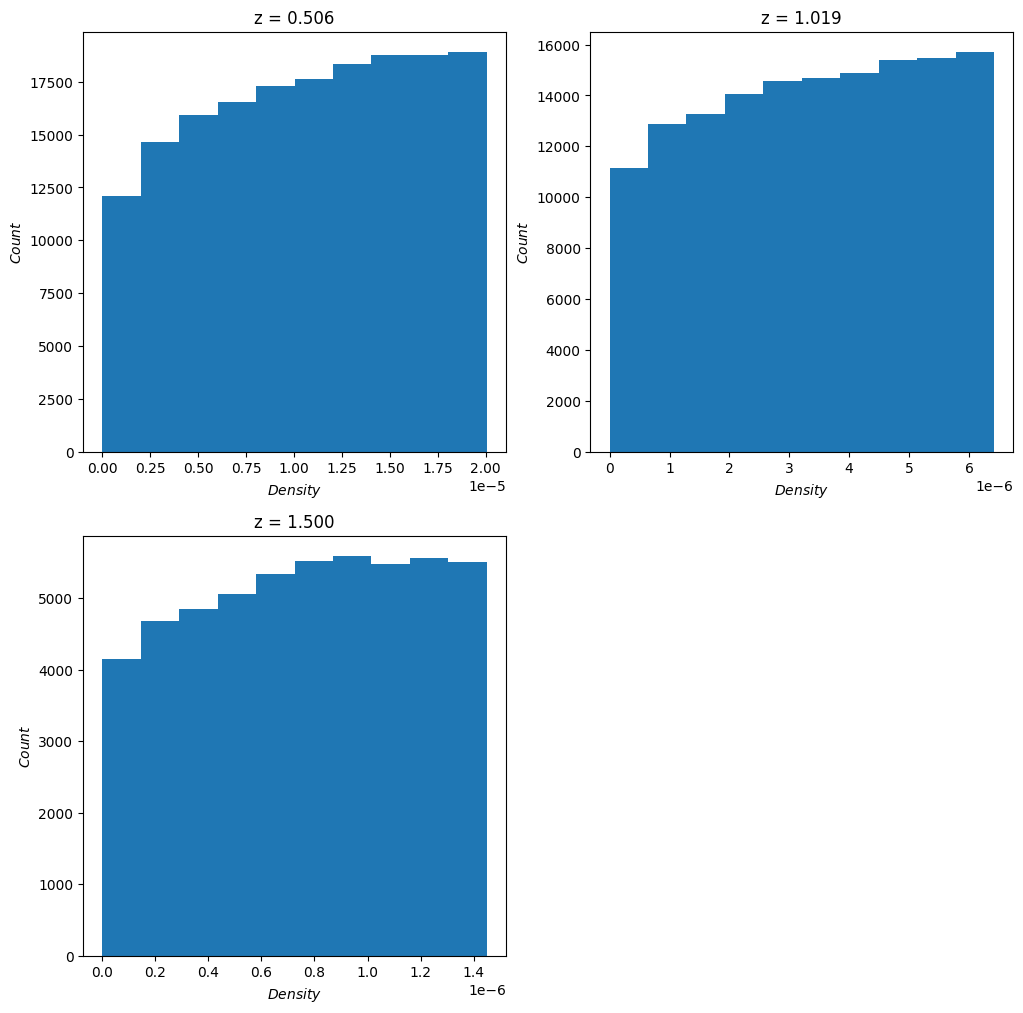

In [23]:
# calculating theoretical cumulative distributions
mfunc1 = mass_function.massFunction(z1['mass'], 0.506, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
mfunc2 = mass_function.massFunction(z2['mass'], 1.019, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')
mfunc3 = mass_function.massFunction(z3['mass'], 1.500, mdef = 'vir', model = 'despali16', q_out = 'dndlnM')

# sketching the cumulative distributions
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
axes[0, 0].hist(mfunc1)
axes[0, 0].set_title('z = 0.506')
axes[0, 1].hist(mfunc2)
axes[0, 1].set_title('z = 1.019')
axes[1, 0].hist(mfunc3)
axes[1, 0].set_title('z = 1.500')
fig.delaxes(axes[1, 1])
for ax in axes.flat:
    ax.set(xlabel = '$Density$', ylabel='$Count$')

## Parte tre: inferenza bayesiana sui parametri cosmologici

### Modelli flat $\Lambda CDM$
_Supponendo che le predizioni teoriche della HMF siano in accordo con i dati osservati, si può procedere con una fase di inferenza bayesiana sui parametri cosmologici._ 

_Analizzare inizialmente i tre bin di redshift individualmente. Ha senso combinarli per un'analisi congiunta?_